# Data Preprocessing

In [1]:
# Import dependencies
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [2]:
# Import PLACES data
places_df = pd.read_csv("./Resources/processed_PLACES_COPD.csv")
places_df = places_df.drop(["State_County"], axis=1)
places_df.head()

,State,County,Levels_Smokers,Levels_COPD
0,Iowa,Cass,19.3,8.3
1,Iowa,Monona,18.5,8.3
2,Alaska,Dillingham,31.1,8.9
3,Colorado,Custer,13.8,7.5
4,Alaska,Ketchikan Gateway,19.4,6.6


In [3]:
# Import Coal Mines data
coal_df = pd.read_csv("./Resources/processed_Coal_Mines.csv")
coal_df = coal_df.drop(["State_County"], axis=1)
coal_df.head()

,State,County,Surface_Mines,Underground_Mines
0,Alabama,Walker,22,2.0
1,Alabama,Jefferson,22,5.0
2,Alabama,Jefferson,13,5.0
3,Alabama,Tuscaloosa,13,12.0
4,Alabama,Jefferson,13,14.0


In [4]:
# Import Air Quality data
aqi_df = pd.read_csv("./Resources/processed_Decade_Air_Quality.csv")
aqi_df = aqi_df.drop(["State_County"], axis=1)
aqi_df.head()

,State,County,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days
0,Alabama,Baldwin,523.0,455.0,66.0,2.0,0.0,0.0,0.0
1,Alabama,Clay,226.0,194.0,32.0,0.0,0.0,0.0,0.0
2,Alabama,Colbert,586.0,472.0,114.0,0.0,0.0,0.0,0.0
3,Alabama,DeKalb,724.0,635.0,89.0,0.0,0.0,0.0,0.0
4,Alabama,Elmore,472.0,436.0,36.0,0.0,0.0,0.0,0.0


In [5]:
# Import Census 2019 data
census_df = pd.read_csv("./Resources/processed_census_data.csv")
census_df = census_df.drop(["State_County"], axis=1)
census_df.head()

,State,County,PERC_TOT_MALE_0,PERC_TOT_FEMALE_0,PERC_WA_MALE_0,PERC_WA_FEMALE_0,PERC_BA_MALE_0,PERC_BA_FEMALE_0,PERC_IA_MALE_0,PERC_IA_FEMALE_0,...,PERC_HWAC_MALE_18,PERC_HWAC_FEMALE_18,PERC_HBAC_MALE_18,PERC_HBAC_FEMALE_18,PERC_HIAC_MALE_18,PERC_HIAC_FEMALE_18,PERC_HAAC_MALE_18,PERC_HAAC_FEMALE_18,PERC_HNAC_MALE_18,PERC_HNAC_FEMALE_18
0,Alabama,Autauga,48.492008,51.507992,37.369561,38.892767,9.373714,10.739408,0.216578,0.259536,...,0.747863,1.282051,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,Alabama,Baldwin,48.490373,51.509627,42.471129,44.969852,4.249353,4.527536,0.404508,0.375839,...,0.427350,0.899685,0.0,0.000000,0.0,0.022492,0.0,0.0,0.000000,0.0
2,Alabama,Barbour,52.920684,47.079316,25.881066,23.272300,25.565098,22.664668,0.417241,0.271409,...,0.639659,0.426439,0.0,0.213220,0.0,0.213220,0.0,0.0,0.000000,0.0
3,Alabama,Bibb,53.268733,46.731267,39.144414,37.621684,13.132982,8.136108,0.236671,0.223274,...,1.028278,0.000000,0.0,0.514139,0.0,0.000000,0.0,0.0,0.000000,0.0
4,Alabama,Blount,49.237367,50.762633,47.137966,48.687442,0.892332,0.798949,0.332031,0.307820,...,1.818182,0.545455,0.0,0.000000,0.0,0.000000,0.0,0.0,0.090909,0.0


In [6]:
# Merge places and coal dataframes
merged_df = pd.merge(places_df, coal_df, on=["State", "County"], how="left")
merged_df

,State,County,Levels_Smokers,Levels_COPD,Surface_Mines,Underground_Mines
0,Iowa,Cass,19.3,8.3,NaN,NaN
1,Iowa,Monona,18.5,8.3,NaN,NaN
2,Alaska,Dillingham,31.1,8.9,NaN,NaN
3,Colorado,Custer,13.8,7.5,NaN,NaN
4,Alaska,Ketchikan Gateway,19.4,6.6,NaN,NaN
...,...,...,...,...,...,...
3176,Wisconsin,Sauk,16.8,6.5,NaN,NaN
3177,Wisconsin,Brown,15.1,5.5,NaN,NaN
3178,West Virginia,Webster,26.8,15.3,NaN,NaN
3179,Wisconsin,Winnebago,17.1,5.8,NaN,NaN


In [7]:
# Merge in the Air Quality data
merged_df = pd.merge(merged_df, aqi_df, on=["State", "County"], how="left")
merged_df

,State,County,Levels_Smokers,Levels_COPD,Surface_Mines,Underground_Mines,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days
0,Iowa,Cass,19.3,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Iowa,Monona,18.5,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alaska,Dillingham,31.1,8.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Colorado,Custer,13.8,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alaska,Ketchikan Gateway,19.4,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176,Wisconsin,Sauk,16.8,6.5,NaN,NaN,678.0,571.0,103.0,4.0,0.0,0.0,0.0
3177,Wisconsin,Brown,15.1,5.5,NaN,NaN,722.0,546.0,168.0,8.0,0.0,0.0,0.0
3178,West Virginia,Webster,26.8,15.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3179,Wisconsin,Winnebago,17.1,5.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Merge in the census data
merged_df = pd.merge(merged_df, census_df, on=["State", "County"], how="left")
pd.set_option('display.max_columns', None)
merged_df

State             County  Levels_Smokers  Levels_COPD  \
0              Iowa               Cass            19.3          8.3   
1              Iowa             Monona            18.5          8.3   
2            Alaska         Dillingham            31.1          8.9   
3          Colorado             Custer            13.8          7.5   
4            Alaska  Ketchikan Gateway            19.4          6.6   
...             ...                ...             ...          ...   
3176      Wisconsin               Sauk            16.8          6.5   
3177      Wisconsin              Brown            15.1          5.5   
3178  West Virginia            Webster            26.8         15.3   
3179      Wisconsin          Winnebago            17.1          5.8   
3180      Wisconsin           Waukesha            12.6          4.7   

      Surface_Mines  Underground_Mines  Days_with_AQI  Good_Days  \
0               NaN                NaN            NaN        NaN   
1               NaN                NaN            NaN        NaN   
2               NaN                NaN            NaN        NaN   
3               NaN                NaN            NaN        NaN   
4               NaN                NaN            NaN        NaN   
...             ...                ...            ...        ...   
3176            NaN                NaN          678.0      571.0   
3177            NaN                NaN          722.0      546.0   
3178            NaN                NaN            NaN        NaN   
3179            NaN                NaN            NaN        NaN   
3180            NaN                NaN          682.0      531.0   

      Moderate_Days  Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  \
0               NaN                                  NaN             NaN   
1               NaN                                  NaN             NaN   
2               NaN                                  NaN             NaN   
3               NaN                                  NaN             NaN   
4               NaN                                  NaN             NaN   
...             ...                                  ...             ...   
3176          103.0                                  4.0             0.0   
3177          168.0                                  8.0             0.0   
3178            NaN                                  NaN             NaN   
3179            NaN                                  NaN             NaN   
3180          148.0                                  3.0             0.0   

      Very_Unhealthy_Days  Hazardous_Days  PERC_TOT_MALE_0  PERC_TOT_FEMALE_0  \
0                     NaN             NaN        49.143035          50.856965   
1                     NaN             NaN        48.450377          51.549623   
2                     NaN             NaN              NaN                NaN   
3                     NaN             NaN        51.696922          48.303078   
4                     NaN             NaN              NaN                NaN   
...                   ...             ...              ...                ...   
3176                  0.0             0.0        49.790509          50.209491   
3177                  0.0             0.0        49.613672          50.386328   
3178                  NaN             NaN        50.295785          49.704215   
3179                  NaN             NaN        50.276021          49.723979   
3180                  0.0             0.0        49.203608          50.796392   

      PERC_WA_MALE_0  PERC_WA_FEMALE_0  PERC_BA_MALE_0  PERC_BA_FEMALE_0  \
0          47.732939         49.470240        0.288252          0.171393   
1          46.523506         49.599536        0.487522          0.243761   
2                NaN               NaN             NaN               NaN   
3          48.618785         45.935280        1.164167          0.434096   
4                NaN               NaN             NaN               NaN   
..

In [9]:
# View null values
merged_df.isnull().sum()

State                     0
County                    1
Levels_Smokers            0
Levels_COPD               0
Surface_Mines          3078
                       ... 
PERC_HIAC_FEMALE_18     296
PERC_HAAC_MALE_18       296
PERC_HAAC_FEMALE_18     296
PERC_HNAC_MALE_18       296
PERC_HNAC_FEMALE_18     296
Length: 1381, dtype: int64

In [10]:
# View the county with a NaN value
merged_df[merged_df['County'].isnull()]

,State,County,Levels_Smokers,Levels_COPD,Surface_Mines,Underground_Mines,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,PERC_TOT_MALE_0,PERC_TOT_FEMALE_0,PERC_WA_MALE_0,PERC_WA_FEMALE_0,PERC_BA_MALE_0,PERC_BA_FEMALE_0,PERC_IA_MALE_0,PERC_IA_FEMALE_0,PERC_AA_MALE_0,PERC_AA_FEMALE_0,PERC_NA_MALE_0,PERC_NA_FEMALE_0,PERC_TOM_MALE_0,PERC_TOM_FEMALE_0,PERC_WAC_MALE_0,PERC_WAC_FEMALE_0,PERC_BAC_MALE_0,PERC_BAC_FEMALE_0,PERC_IAC_MALE_0,PERC_IAC_FEMALE_0,PERC_AAC_MALE_0,PERC_AAC_FEMALE_0,PERC_NAC_MALE_0,PERC_NAC_FEMALE_0,PERC_NH_MALE_0,PERC_NH_FEMALE_0,PERC_NHWA_MALE_0,PERC_NHWA_FEMALE_0,PERC_NHBA_MALE_0,PERC_NHBA_FEMALE_0,PERC_NHIA_MALE_0,PERC_NHIA_FEMALE_0,PERC_NHAA_MALE_0,PERC_NHAA_FEMALE_0,PERC_NHNA_MALE_0,PERC_NHNA_FEMALE_0,PERC_NHTOM_MALE_0,PERC_NHTOM_FEMALE_0,PERC_NHWAC_MALE_0,PERC_NHWAC_FEMALE_0,PERC_NHBAC_MALE_0,PERC_NHBAC_FEMALE_0,PERC_NHIAC_MALE_0,PERC_NHIAC_FEMALE_0,PERC_NHAAC_MALE_0,PERC_NHAAC_FEMALE_0,PERC_NHNAC_MALE_0,PERC_NHNAC_FEMALE_0,PERC_H_MALE_0,PERC_H_FEMALE_0,PERC_HWA_MALE_0,PERC_HWA_FEMALE_0,PERC_HBA_MALE_0,PERC_HBA_FEMALE_0,PERC_HIA_MALE_0,PERC_HIA_FEMALE_0,PERC_HAA_MALE_0,PERC_HAA_FEMALE_0,PERC_HNA_MALE_0,PERC_HNA_FEMALE_0,PERC_HTOM_MALE_0,PERC_HTOM_FEMALE_0,PERC_HWAC_MALE_0,PERC_HWAC_FEMALE_0,PERC_HBAC_MALE_0,PERC_HBAC_FEMALE_0,PERC_HIAC_MALE_0,PERC_HIAC_FEMALE_0,PERC_HAAC_MALE_0,PERC_HAAC_FEMALE_0,PERC_HNAC_MALE_0,PERC_HNAC_FEMALE_0,PERC_TOT_MALE_1,PERC_TOT_FEMALE_1,PERC_WA_MALE_1,PERC_WA_FEMALE_1,PERC_BA_MALE_1,PERC_BA_FEMALE_1,PERC_IA_MALE_1,PERC_IA_FEMALE_1,PERC_AA_MALE_1,PERC_AA_FEMALE_1,PERC_NA_MALE_1,PERC_NA_FEMALE_1,PERC_TOM_MALE_1,PERC_TOM_FEMALE_1,PERC_WAC_MALE_1,PERC_WAC_FEMALE_1,PERC_BAC_MALE_1,PERC_BAC_FEMALE_1,PERC_IAC_MALE_1,PERC_IAC_FEMALE_1,PERC_AAC_MALE_1,PERC_AAC_FEMALE_1,PERC_NAC_MALE_1,PERC_NAC_FEMALE_1,PERC_NH_MALE_1,PERC_NH_FEMALE_1,PERC_NHWA_MALE_1,PERC_NHWA_FEMALE_1,PERC_NHBA_MALE_1,PERC_NHBA_FEMALE_1,PERC_NHIA_MALE_1,PERC_NHIA_FEMALE_1,PERC_NHAA_MALE_1,PERC_NHAA_FEMALE_1,PERC_NHNA_MALE_1,PERC_NHNA_FEMALE_1,PERC_NHTOM_MALE_1,PERC_NHTOM_FEMALE_1,PERC_NHWAC_MALE_1,PERC_NHWAC_FEMALE_1,PERC_NHBAC_MALE_1,PERC_NHBAC_FEMALE_1,PERC_NHIAC_MALE_1,PERC_NHIAC_FEMALE_1,PERC_NHAAC_MALE_1,PERC_NHAAC_FEMALE_1,PERC_NHNAC_MALE_1,PERC_NHNAC_FEMALE_1,PERC_H_MALE_1,PERC_H_FEMALE_1,PERC_HWA_MALE_1,PERC_HWA_FEMALE_1,PERC_HBA_MALE_1,PERC_HBA_FEMALE_1,PERC_HIA_MALE_1,PERC_HIA_FEMALE_1,PERC_HAA_MALE_1,PERC_HAA_FEMALE_1,PERC_HNA_MALE_1,PERC_HNA_FEMALE_1,PERC_HTOM_MALE_1,PERC_HTOM_FEMALE_1,PERC_HWAC_MALE_1,PERC_HWAC_FEMALE_1,PERC_HBAC_MALE_1,PERC_HBAC_FEMALE_1,PERC_HIAC_MALE_1,PERC_HIAC_FEMALE_1,PERC_HAAC_MALE_1,PERC_HAAC_FEMALE_1,PERC_HNAC_MALE_1,PERC_HNAC_FEMALE_1,PERC_TOT_MALE_2,PERC_TOT_FEMALE_2,PERC_WA_MALE_2,PERC_WA_FEMALE_2,PERC_BA_MALE_2,PERC_BA_FEMALE_2,PERC_IA_MALE_2,PERC_IA_FEMALE_2,PERC_AA_MALE_2,PERC_AA_FEMALE_2,PERC_NA_MALE_2,PERC_NA_FEMALE_2,PERC_TOM_MALE_2,PERC_TOM_FEMALE_2,PERC_WAC_MALE_2,PERC_WAC_FEMALE_2,PERC_BAC_MALE_2,PERC_BAC_FEMALE_2,PERC_IAC_MALE_2,PERC_IAC_FEMALE_2,PERC_AAC_MALE_2,PERC_AAC_FEMALE_2,PERC_NAC_MALE_2,PERC_NAC_FEMALE_2,PERC_NH_MALE_2,PERC_NH_FEMALE_2,PERC_NHWA_MALE_2,PERC_NHWA_FEMALE_2,PERC_NHBA_MALE_2,PERC_NHBA_FEMALE_2,PERC_NHIA_MALE_2,PERC_NHIA_FEMALE_2,PERC_NHAA_MALE_2,PERC_NHAA_FEMALE_2,PERC_NHNA_MALE_2,PERC_NHNA_FEMALE_2,PERC_NHTOM_MALE_2,PERC_NHTOM_FEMALE_2,PERC_NHWAC_MALE_2,PERC_NHWAC_FEMALE_2,PERC_NHBAC_MALE_2,PERC_NHBAC_FEMALE_2,PERC_NHIAC_MALE_2,PERC_NHIAC_FEMALE_2,PERC_NHAAC_MALE_2,PERC_NHAAC_FEMALE_2,PERC_NHNAC_MALE_2,PERC_NHNAC_FEMALE_2,PERC_H_MALE_2,PERC_H_FEMALE_2,PERC_HWA_MALE_2,PERC_HWA_FEMALE_2,PERC_HBA_MALE_2,PERC_HBA_FEMALE_2,PERC_HIA_MALE_2,PERC_HIA_FEMALE_2,PERC_HAA_MALE_2,PERC_HAA_FEMALE_2,PERC_HNA_MALE_2,PERC_HNA_FEMALE_2,PERC_HTOM_MALE_2,PERC_HTOM_FEMALE_2,PERC_HWAC_MALE_2,PERC_HWAC_FEMALE_2,PERC_HBAC_MALE_2,PERC_HBAC_FEMALE_2,PERC_HIAC_MALE_2,PERC_HIAC_FEMALE_2,PERC_HAAC_MALE_2,PERC_HAAC_FEMALE_2,PERC_HNAC_MALE_2,PERC_HNAC_FEMALE_2,PERC_TOT_MALE_3,PERC_TOT_FEMALE_3,PERC_WA

In [11]:
# Drop the row containing "United States"
merged_df = merged_df[merged_df.State != "United States"]
merged_df.isnull().sum()

State                     0
County                    0
Levels_Smokers            0
Levels_COPD               0
Surface_Mines          3077
                       ... 
PERC_HIAC_FEMALE_18     295
PERC_HAAC_MALE_18       295
PERC_HAAC_FEMALE_18     295
PERC_HNAC_MALE_18       295
PERC_HNAC_FEMALE_18     295
Length: 1381, dtype: int64

In [12]:
# Fill Nulls from states without mines to be 0
merged_df = merged_df.fillna(0)
merged_df.isnull().sum()

State                  0
County                 0
Levels_Smokers         0
Levels_COPD            0
Surface_Mines          0
                      ..
PERC_HIAC_FEMALE_18    0
PERC_HAAC_MALE_18      0
PERC_HAAC_FEMALE_18    0
PERC_HNAC_MALE_18      0
PERC_HNAC_FEMALE_18    0
Length: 1381, dtype: int64

In [13]:
# Drop County name as it might confuse the model
merged_df = merged_df.drop(["County"], axis=1)

# Encode the Data

In [14]:
# Prepare for label encoding
le = LabelEncoder()
encoded_df = merged_df.copy()

In [15]:
# Filter all string object data types into a dataframe_cat for encoding
dataframe_cat = merged_df.dtypes[merged_df.dtypes == "object"].index.tolist()

dataframe_cat

['State']

In [16]:
# For loop to encode text columns to numerical values
for column in dataframe_cat:
    encoded_df[column] = le.fit_transform(merged_df[column])


encoded_df.head()

State  Levels_Smokers  Levels_COPD  Surface_Mines  Underground_Mines  \
0     15            19.3          8.3            0.0                0.0   
1     15            18.5          8.3            0.0                0.0   
2      1            31.1          8.9            0.0                0.0   
3      5            13.8          7.5            0.0                0.0   
4      1            19.4          6.6            0.0                0.0   

   Days_with_AQI  Good_Days  Moderate_Days  \
0            0.0        0.0            0.0   
1            0.0        0.0            0.0   
2            0.0        0.0            0.0   
3            0.0        0.0            0.0   
4            0.0        0.0            0.0   

   Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  Very_Unhealthy_Days  \
0                                  0.0             0.0                  0.0   
1                                  0.0             0.0                  0.0   
2                                  0.0             0.0                  0.0   
3                                  0.0             0.0                  0.0   
4                                  0.0             0.0                  0.0   

   Hazardous_Days  PERC_TOT_MALE_0  PERC_TOT_FEMALE_0  PERC_WA_MALE_0  \
0             0.0        49.143035          50.856965       47.732939   
1             0.0        48.450377          51.549623       46.523506   
2             0.0         0.000000           0.000000        0.000000   
3             0.0        51.696922          48.303078       48.618785   
4             0.0         0.000000           0.000000        0.000000   

   PERC_WA_FEMALE_0  PERC_BA_MALE_0  PERC_BA_FEMALE_0  PERC_IA_MALE_0  \
0         49.470240        0.288252          0.171393        0.218136   
1         49.599536        0.487522          0.243761        0.591991   
2          0.000000        0.000000          0.000000        0.000000   
3         45.935280        1.164167          0.434096        0.730071   
4          0.000000        0.000000          0.000000        0.000000   

   PERC_IA_FEMALE_0  PERC_AA_MALE_0  PERC_AA_FEMALE_0  PERC_NA_MALE_0  \
0          0.241508        0.186974          0.288252        0.210346   
1          0.940221        0.104469          0.174115        0.127684   
2          0.000000        0.000000          0.000000        0.000000   
3          0.493291        0.177585          0.335438        0.019732   
4          0.000000        0.000000          0.000000        0.000000   

   PERC_NA_FEMALE_0  PERC_TOM_MALE_0  PERC_TOM_FEMALE_0  PERC_WAC_MALE_0  \
0          0.272671         0.506388           0.412901        48.231536   
1          0.069646         0.615206           0.522345        47.115496   
2          0.000000         0.000000           0.000000         0.000000   
3          0.000000         0.986582           1.104972        49.546172   
4          0.000000         0.000000           0.000000         0.000000   

   PERC_WAC_FEMALE_0  PERC_BAC_MALE_0  PERC_BAC_FEMALE_0  PERC_IAC_MALE_0  \
0          49.851979         0.560922           0.405111         0.381739   
1          50.098665         0.835752           0.522345         0.777713   
2           0.000000         0.000000           0.000000         0.000000   
3          46.941594         1.420679           0.690608         1.302289   
4           0.000000         0.000000           0.000000         0.000000   

   PERC_IAC_FEMALE_0  PERC_AAC_MALE_0  PERC_AAC_FEMALE_0  PERC_NAC_MALE_0  \
0           0.389529         0.272671           0.350577         0.218136   
1           1.102728         0.232153           0.278584         0.127684   
2           0.000000         0.000000           0.000000         0.000000   
3           1.164167         0.374901           0.532755         0.039463   
4           0.000000         0.000000           0.000000         0.000000   

   PERC_NAC_FEMALE_0  PERC_NH_MALE_0  PERC_NH_FEMALE_0  PERC_NHWA_MALE_0  \
0           0.288252    

# Split, Train, Test

In [17]:
# Split our preprocessed data into our features and target arrays
X = encoded_df.drop("Levels_COPD", axis=1)
y = encoded_df["Levels_COPD"]


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Find Correlation Between Features and Target

In [19]:
correlation_df = encoded_df[["State", "Levels_Smokers", "Surface_Mines", 
                             "Underground_Mines", "Good_Days", "Levels_COPD"]]

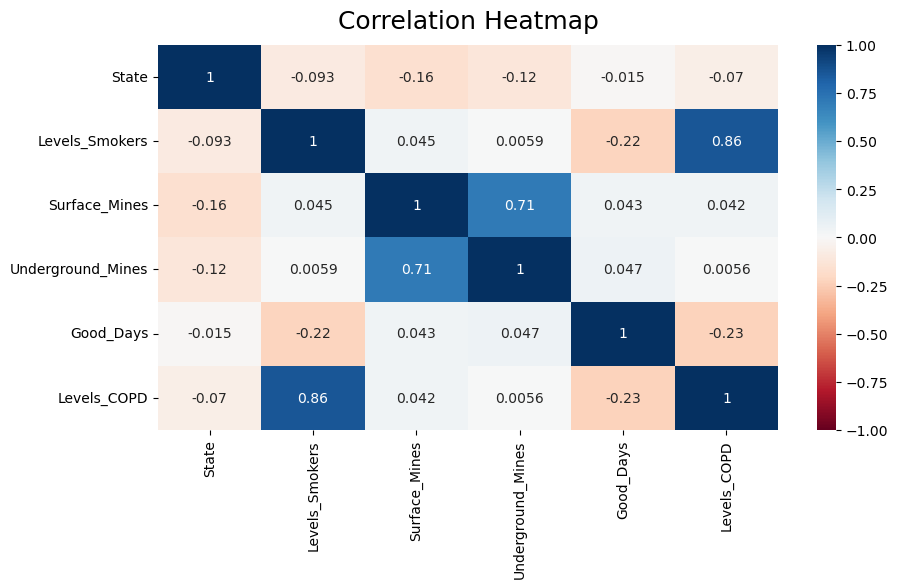

In [20]:
plt.figure(figsize=(10, 5))
heatmap = sb.heatmap(correlation_df.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [21]:
len(X_train.columns)

1379

In [22]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train.columns)
hidden_nodes_layer1 = len(X_train.columns) / 2
hidden_nodes_layer2 = len(X_train.columns) / 3
hidden_nodes_layer3 = len(X_train.columns) / 4
# hidden_nodes_layer4 = len(X_train[0]) / 5
# hidden_nodes_layer5 = len(X_train[0]) / 6

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# # Fourth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# # Fifth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 689)               950820    
                                                                 
 dense_1 (Dense)             (None, 459)               316710    
                                                                 
 dense_2 (Dense)             (None, 344)               158240    
                                                                 
 dense_3 (Dense)             (None, 1)                 345       
                                                                 
Total params: 1,426,115
Trainable params: 1,426,115
Non-trainable params: 0
_________________________________________________________________


2022-11-18 21:19:27.460563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 21:19:27.460664: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# # Import checkpoint dependencies
# import os
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the checkpoint path and filenames
# os.makedirs("optimized_checkpoints/",exist_ok=True)
# checkpoint_path = "optimized_checkpoints/weights.{epoch:02d}.hdf5"

In [24]:
# Compile the model
nn.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])



# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = ModelCheckpoint(
#     filepath = checkpoint_path,
#     verbose = 1,
#     save_weights_only = True,
#     save_freq = 5
# )

In [25]:
# Train the model
# fit_model = nn.fit(X_train_scaled, y_train, epochs=1, callbacks=[cp_callback])
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=75)


Epoch 1/75


2022-11-18 21:19:27.603677: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 9/75 [==>...........................] - ETA: 0s - loss: 3.8657 - root_mean_squared_error: 4.9694 

2022-11-18 21:19:27.855482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 1s 7ms/step - loss: 1.9634 - root_mean_squared_error: 2.8084
Epoch 2/75
75/75 [==============================] - 0s 6ms/step - loss: 1.3404 - root_mean_squared_error: 1.8863
Epoch 3/75
75/75 [==============================] - 0s 6ms/step - loss: 1.3029 - root_mean_squared_error: 2.5870
Epoch 4/75
75/75 [==============================] - 0s 6ms/step - loss: 1.0837 - root_mean_squared_error: 1.7583
Epoch 5/75
75/75 [==============================] - 0s 6ms/step - loss: 1.0782 - root_mean_squared_error: 1.5171
Epoch 6/75
75/75 [==============================] - 0s 7ms/step - loss: 0.9282 - root_mean_squared_error: 1.5767
Epoch 7/75
75/75 [==============================] - 0s 6ms/step - loss: 0.8667 - root_mean_squared_error: 1.1931
Epoch 8/75
75/75 [==============================] - 0s 7ms/step - loss: 0.8715 - root_mean_squared_error: 1.2003
Epoch 9/75
75/75 [==============================] - 0s 7ms/step - loss: 0.8422 - root_mean_squared_error: 1

75/75 [==============================] - 1s 7ms/step - loss: 0.3766 - root_mean_squared_error: 0.5903
Epoch 74/75
75/75 [==============================] - 0s 7ms/step - loss: 0.3729 - root_mean_squared_error: 0.6097
Epoch 75/75
75/75 [==============================] - 1s 7ms/step - loss: 0.3603 - root_mean_squared_error: 0.5875


In [26]:
fit_model.history

{'loss': [1.963421106338501,
  1.3404477834701538,
  1.3028950691223145,
  1.0836995840072632,
  1.0782281160354614,
  0.928240180015564,
  0.8667421936988831,
  0.8714521527290344,
  0.8422120809555054,
  0.7728042006492615,
  0.8835317492485046,
  0.7148835062980652,
  0.7272252440452576,
  0.695814847946167,
  0.7247858047485352,
  0.6956447958946228,
  0.5813568830490112,
  0.6651598215103149,
  0.6096368432044983,
  0.6078089475631714,
  0.6038607358932495,
  0.6454384922981262,
  0.6234720945358276,
  0.5634472966194153,
  0.5512284636497498,
  0.5325796008110046,
  0.5543323755264282,
  0.5259831547737122,
  0.5546228885650635,
  0.5494765043258667,
  0.5131089091300964,
  0.5351465344429016,
  0.5036623477935791,
  0.4951891005039215,
  0.5134090185165405,
  0.503875195980072,
  0.4847637414932251,
  0.5225081443786621,
  0.5009974837303162,
  0.4518201947212219,
  0.47257742285728455,
  0.45002827048301697,
  0.44224539399147034,
  0.4748290479183197,
  0.4976138174533844,
  0

In [27]:
history = fit_model

In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['root_mean_squared_error'], label='RMSE')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('% Error [Level_COPD]')
  plt.legend()
  plt.grid(True)

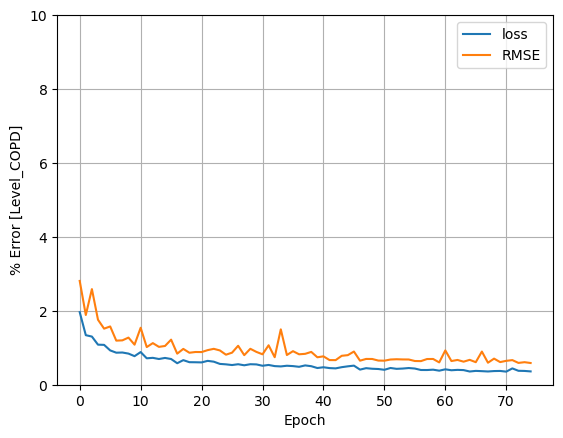

In [29]:
plot_loss(history)

In [33]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, RMSE: {model_accuracy}")

25/25 - 0s - loss: 0.7805 - root_mean_squared_error: 1.1234 - 95ms/epoch - 4ms/step
Loss: 0.7804729342460632, RMSE: 1.1234122514724731


In [31]:
# # Export our model to HDF5 file
# nn.save('COPD_DeepLearning.h5')

In [34]:
X_train

State  Levels_Smokers  Surface_Mines  Underground_Mines  Days_with_AQI  \
2402     36            17.4            0.0                0.0          724.0   
2971     45             8.8            0.0                0.0            0.0   
2309     37            19.1            0.0                0.0            0.0   
393       5            14.4            0.0                0.0          238.0   
27        0            22.8            0.0                0.0            0.0   
...     ...             ...            ...                ...            ...   
764      13            21.0            2.0                2.0          688.0   
836      14            21.7            0.0                0.0            0.0   
1654     24            23.6            0.0                0.0            0.0   
2608     42            14.6            0.0                0.0            0.0   
2733     42            21.3            0.0                0.0            0.0   

      Good_Days  Moderate_Days  Unhealthy_for_Sensitive_Groups_Days  \
2402      525.0          194.0                                  5.0   
2971        0.0            0.0                                  0.0   
2309        0.0            0.0                                  0.0   
393       237.0            1.0                                  0.0   
27          0.0            0.0                                  0.0   
...         ...            ...                                  ...   
764       604.0           84.0                                  0.0   
836         0.0            0.0                                  0.0   
1654        0.0            0.0                                  0.0   
2608        0.0            0.0                                  0.0   
2733        0.0            0.0                                  0.0   

      Unhealthy_Days  Very_Unhealthy_Days  Hazardous_Days  PERC_TOT_MALE_0  \
2402             0.0                  0.0             0.0        50.926552   
2971             0.0                  0.0             0.0         0.000000   
2309             0.0                  0.0             0.0        54.617902   
393              0.0                  0.0             0.0         0.000000   
27               0.0                  0.0             0.0        49.230873   
...              ...                  ...             ...              ...   
764              0.0                  0.0             0.0        55.122396   
836              0.0                  0.0             0.0        50.443364   
1654             0.0                  0.0             0.0        46.113553   
2608             0.0                  0.0             0.0        49.473470   
2733             0.0                  0.0             0.0        48.051328   

      PERC_TOT_FEMALE_0  PERC_WA_MALE_0  PERC_WA_FEMALE_0  PERC_BA_MALE_0  \
2402          49.073448       46.057081         44.569187        0.635737   
2971           0.000000        0.000000          0.000000        0.000000   
2309          45.382098       45.727133         42.957950        6.684772   
393            0.000000        0.000000          0.000000        0.000000   
27            50.769127       45.969235         48.072975        2.235013   
...                 ...             ...               ...             ...   
764           44.877604       44.861871         42.284941        9.105783   
836           49.556636       48.755721         47.675915        0.614989   
1654          53.886447       12.651165         13.127149       32.576465   
2608          50.526530       42.142801         42.990884        4.559866   
2733          51.948672       42.283803         45.396219        4.238619   

      PERC_BA_FEMALE_0  PERC_IA_MALE_0  PERC_IA_FEMALE_0  PERC_AA_MALE_0  \
2402          0.405789        2.218315          2.204788        0.229947   
2971          0.000000        0.000000          0.000000        0.000000   
2309          0.814727        0.434076          0.133562        0.892639   
393           0.000000    